In [1]:
%%HTML
<style>
h1 {
    text-align: center;
    color: #3673A3;
}

h3, h4, h5 {
    color: #C18C4E;
}
</style>

In [2]:
import requests
import sys
import io
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup as bs
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter
from bokeh.models.tools import HoverTool
from IPython.display import display, HTML

url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"
hist_covid = requests.get(url_json)
url = requests.get(url_csv).content

soup_covid = bs(hist_covid.text, features="html.parser")
awnser_code = hist_covid.status_code
data = pd.read_csv(io.StringIO(url.decode('utf-8')))
df = pd.DataFrame(data)
df_head = df.head(11)
list_columns = df.columns.values.tolist()

if awnser_code != 200:
    print("Error en la lectura de datos.")
    sys.exit()
json_covid = hist_covid.json()

In [3]:
display(HTML('<h1>Estadisticas de COVID-19 en Estados Unidos</h1>'))
display(HTML('<hr>'))
display(HTML('<h3>Cantidad de registros: ' + str(len(df)) + '</h3>'))
display(HTML('<h3>Columnas del dataset: ' + str(len(df.columns)) + '</h3>'))
display(HTML(pd.DataFrame(list_columns).to_html(index=False)))
display(HTML('<h3>Información del dataset: </h3>'))

0
date
state
positive
probableCases
negative
pending
totalTestResultsSource
totalTestResults
hospitalizedCurrently
hospitalizedCumulative


In [4]:
info_dataset = df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         20780 non-null  int64  
 1   state                        20780 non-null  object 
 2   positive                     20592 non-null  float64
 3   probableCases                9271 non-null   float64
 4   negative                     13290 non-null  float64
 5   pending                      2138 non-null   float64
 6   totalTestResultsSource       20780 non-null  object 
 7   totalTestResults             20614 non-null  float64
 8   hospitalizedCurrently        17339 non-null  float64
 9   hospitalizedCumulative       12382 non-null  float64
 10  inIcuCurrently               11636 non-null  float64
 11  inIcuCumulative              3789 non-null   float64
 12  onVentilatorCurrently        9126 non-null   float64
 13  onVentilatorCumu

In [5]:
display(HTML('<hr>'))
display(HTML('<h3>Datos perdidos por columna</h3>'))
display(HTML(df.isnull().sum().to_frame().to_html()))

,0
date,0
state,0
positive,188
probableCases,11509
negative,7490
pending,18642
totalTestResultsSource,0
totalTestResults,166
hospitalizedCurrently,3441
hospitalizedCumulative,8398


In [6]:
display(HTML('<hr>'))
display(HTML('<h3>Estadisticas del dataset</h3>'))
display(HTML(df.describe().to_html()))

,date,positive,probableCases,negative,pending,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,hospitalizedDischarged,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,dataQualityGrade,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
count,2.078000e+04,2.059200e+04,9271.000000,1.329000e+04,2138.000000,2.061400e+04,17339.000000,12382.000000,11636.000000,3789.000000,9126.000000,1290.000000,1.200300e+04,19930.000000,12382.000000,3070.000000,1.451600e+04,8.958000e+03,5.024000e+03,1.424600e+04,9422.000000,7593.000000,5.231000e+03,9.197000e+03,4.789000e+03,3346.000000,1458.000000,2200.000000,1094.000000,972.000000,999.000000,633.000000,3.421000e+03,2233.000000,20780.000000,20780.000000,20780.000000,2.078000e+04,20780.000000,2.078000e+04,0.0,20780.000000,20780.000000,20780.0,20780.0,20780.0,20780.0,20780.0,0.0
mean,2.020244e+07,1.651560e+05,21729.123719,8.482246e+05,1659.862956,2.186936e+06,1190.576965,9262.762478,359.621176,1934.191607,151.589305,574.659690,9.424223e+04,3682.216859,9262.762478,64490.165798,2.304555e+06,1.985001e+05,1.818574e+06,1.786625e+05,3770.182764,417.291321,2.702109e+06,9.650105e+05,1.634028e+05,19811.346683,145580.733196,165431.783182,20516.966179,188710.969136,168188.246246,25259.048973,3.089196e+05,31837.241379,32.478200,1383.849519,3589.128874,7.063208e+05,17508.388210,7.061500e+05,NaN,24.790712,37.360780,0.0,0.0,0.0,0.0,0.0,NaN
std,3.608732e+03,3.267852e+05,45471.459778,1.344501e+06,4671.028548,4.436508e+06,2060.041207,12620.544081,594.831150,1953.329983,207.755157,434.603472,2.110372e+05,6281.366321,12620.544081,120753.790723,4.445365e+06,3.514995e+05,2.495555e+06,3.350851e+05,4157.640633,537.625982,5.070893e+06,1.415215e+06,2.016978e+05,28745.649916,190042.827960,178181.836898,29267.559775,200218.073746,143748.073365,24139.253458,4.232854e+05,41929.658070,18.804824,3023.558742,11577.190442,1.300339e+06,33586.022461,1.299997e+06,NaN,60.162742,208.237151,0.0,0.0,0.0,0.0,0.0,NaN
min,2.020011e+07,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000,0.000000,6.000000,0.000000,32.000000,2.000000e+00,0.000000,1.000000,35.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,587.000000,1.000000,0.000000,1.000000,3.000000,3.000000,1.000000e+00,0.000000,1.000000,-7757.000000,-968686.000000,0.000000e+00,-130545.000000,0.000000e+00,NaN,-201.000000,-12257.000000,0.0,0.0,0.0,0.0,0.0,NaN
25%,2.020060e+07,5.753750e+03,773.500000,5.394125e+04,43.000000,1.040498e+05,166.500000,985.250000,60.000000,501.000000,29.000000,220.250000,3.379000e+03,161.250000,985.250000,5370.500000,1.324600e+05,1.615925e+04,3.032998e+05,1.037575e+04,607.000000,79.000000,1.937935e+05,1.414700e+05,1.896500e+04,852.000000,11242.000000,54912.750000,3155.500000,54874.000000,37675.500000,2682.000000,2.004700e+04,1085.000000,18.000000,65.000000,0.000000,2.577975e+04,1205.750000,2.565875e+04,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
50%,2.020090e+07,4.606450e+04,4491.000000,3.059720e+05,212.500000,6.552670e+05,531.000000,4472.000000,172.000000,1295.000000,86.000000,412.000000,1.761800e+04,1108.000000,4472.000000,22021.000000,7.316510e+05,6.535900e+04,9.365995e+05,6.844150e+04,2409.500000,216.000000,9.053220e+05,4.193720e+05,8.465200e+04,8624.000000,78888.000000,103967.500000,11956.000000,100282.000000,144130.000000,17763.000000,1.233840e+05,13661.000000,31.000000,435.000000,141

In [7]:
display(HTML('<hr>'))
display(HTML('<h3>Muestra del dataset</h3>'))

In [8]:
df_head

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,AK,56886.0,NaN,NaN,NaN,totalTestsViral,1731628.0,33.0,1293.0,...,NaN,0,0,dc4bccd4bb885349d7e94d6fed058e285d4be164,0,0,0,0,0,NaN
1,20210307,AL,499819.0,107742.0,1931711.0,NaN,totalTestsPeopleViral,2323788.0,494.0,45976.0,...,NaN,-1,0,997207b430824ea40b8eb8506c19a93e07bc972e,0,0,0,0,0,NaN
2,20210307,AR,324818.0,69092.0,2480716.0,NaN,totalTestsViral,2736442.0,335.0,14926.0,...,NaN,22,11,50921aeefba3e30d31623aa495b47fb2ecc72fae,0,0,0,0,0,NaN
3,20210307,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,NaN,0,0,f77912d0b80d579fbb6202fa1a90554fc4dc1443,0,0,0,0,0,NaN
4,20210307,AZ,826454.0,56519.0,3073010.0,NaN,totalTestsViral,7908105.0,963.0,57907.0,...,NaN,5,44,0437a7a96f4471666f775e63e86923eb5cbd8cdf,0,0,0,0,0,NaN
5,20210307,CA,3501394.0,NaN,NaN,NaN,totalTestsViral,49646014.0,4291.0,NaN,...,NaN,258,0,63c5c0fd2daef2fb65150e9db486de98ed3f7b72,0,0,0,0,0,NaN
6,20210307,CO,436602.0,24786.0,2199458.0,NaN,totalTestEncountersViral,6415123.0,326.0,23904.0,...,NaN,3,18,444746cda3a596f183f3fa3269c8cab68704e819,0,0,0,0,0,NaN
7,20210307,CT,285330.0,19621.0,NaN,NaN,totalTestsViral,6520366.0,428.0,NaN,...,NaN,0,0,38f39494134d22cd0d06e4ce63aa4a4ac10aa930,0,0,0,0,0,NaN
8,20210307,DC,41419.0,NaN,NaN,NaN,totalTestEncountersViral,1261363.0,150.0,NaN,...,NaN,0,0,a3aa0d623d538807fb9577ad64354f48cf728cc8,0,0,0,0,0,NaN
9,20210307,DE,88354.0,4733.0,545070.0,NaN,totalTestEncountersViral,1431942.0,104.0,NaN,...,NaN,9,0,059d870e689d5cc19c35f5eb398214d7d9856373,0,0,0,0,0,NaN


In [9]:
numeric_columns = ['positive', 'positiveCasesViral', 'recovered', 'death']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

confirmed_possitives = df.groupby('state')['positive'].max()
confirmed_cases_viral = df.groupby('state')['positiveCasesViral'].max()
confirmed_recovers = df.groupby('state')['recovered'].max()
confirmed_deaths = df.groupby('state')['death'].max()

total_possitives = '{:,.0f}'.format(confirmed_possitives.sum())
total_confirmed_positives = '{:,.0f}'.format(confirmed_cases_viral.sum())
total_recovers = '{:,.0f}'.format(confirmed_recovers.sum())
total_deaths = '{:,.0f}'.format(confirmed_deaths.sum())

display(HTML('<hr>'))
display(HTML('<h4>Casos positivos con posibilidad de contagio: ' + str(total_possitives) + '</h4>'))
display(HTML('<h4>Casos positivos confirmados: ' + str(total_confirmed_positives) + '</h4>'))
display(HTML('<h4>Recuperados: ' + str(total_recovers) + '</h4>'))
display(HTML('<h4>Muertes: ' + str(total_deaths) + '</h4>'))

In [10]:
display(HTML('<hr>'))
display(HTML('<h3>Eliminamos columnas que no contienen apenas datos y creamos un nuevo dataset</h3>'))

- la columna **dataQualityGrade** tiene 20780 valores nulos, lo que significa que todos los valores en esa columna son nulos.
- la columna **grade** tiene 20780 valores nulos, lo que significa que todos los valores en esa columna son nulos.
- la columna **hash** no le faltan datos, pero son totalmente irrelevantes para el analisis.

In [11]:
df = df.drop(['grade', 'hash', 'dataQualityGrade'], axis=1)
df = pd.DataFrame(json_covid)
df.fillna(0, inplace=True) # Rellenar con 0 los valores faltantes (si los hay)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d') # Convertir la columna de fecha al tipo de dato datetime
descripcion = df.describe() # Datos promedio

#### Información relevante:

#### Aproximadamente 11.221 datos representan el 54% del total de 20,780 datos (100%).

En base a esto, se van a tener en cuenta todas aquellas columnas en las un 54% o más de sus datos, sean nulos o iguales a cero, para considerar cuales de estas deben ignorarse para el futuro analisis del dataframe.

* __pending:__ Número de pruebas pendientes de resultado. (18,688 valores faltantes o iguales a cero).

* __onVentilatorCumulative:__ Número acumulado de personas en ventilación mecánica. (19,490 valores faltantes o iguales a cero).

* __positiveTestsPeopleAntigen:__ Número de personas con pruebas de antígenos positivas. (20,147 valores faltantes o iguales a cero).

* __commercialScore:__ Puntuación comercial. (20,780 valores faltantes o iguales a cero).

* __negativeRegularScore:__ Puntuación negativa regular. (20,780 valores faltantes o iguales a cero).

* __negativeScore:__ Puntuación negativa. (20,780 valores faltantes o iguales a cero).

* __positiveScore:__ Puntuación positiva. (20,780 valores faltantes o iguales a cero).

* __score:__ Puntuación. (20,780 valores faltantes o iguales a cero).

* __negativeTestsPeopleAntibody:__ Número de personas con pruebas de anticuerpos negativas. (19,808 valores faltantes o iguales a cero).

* __dataQualityGrade:__ Calificación de calidad de los datos (todos los valores son NaN). (20,780 valores faltantes o iguales a cero).

* __negativeTestsAntibody:__ Número de pruebas de anticuerpos con resultados negativos. (19,322 valores faltantes o iguales a cero).

* __totalTestsPeopleAntigen:__ Número total de personas sometidas a pruebas de antígenos. (19,781 valores faltantes o iguales a cero).

* __positiveTestsPeopleAntibody:__ Número de personas con pruebas de anticuerpos positivas. (19,699 valores faltantes o iguales a cero).

* __totalTestsAntigen:__ Número total de pruebas de antígenos realizadas. (17,359 valores faltantes o iguales a cero).

* __positiveTestsAntibody:__ Número de pruebas de anticuerpos con resultados positivos. (17,435 valores faltantes o iguales a cero).

* __totalTestEncountersViral:__ Número total de encuentros de pruebas virales. (15,589 valores faltantes o iguales a cero).

* __deathProbable:__ Número de fallecimientos probables. (13,267 valores faltantes o iguales a cero).

* __deathConfirmed:__ Número de fallecimientos confirmados. (11,391 valores faltantes o iguales a cero).

* __positiveTestsViral:__ Número de pruebas virales con resultados positivos. (11,907 valores faltantes o iguales a cero).

* __totalTestsPeopleViral:__ Número total de personas sometidas a pruebas virales. (11,587 valores faltantes o iguales a cero).

* __totalTestsAntibody:__ Número total de pruebas de anticuerpos realizadas. (16,023 valores faltantes o iguales a cero).

* __hospitalizedDischarged:__ Número de personas dadas de alta del hospital. (17,710 valores faltantes o iguales a cero).

* __totalTestsPeopleAntibody:__ Número total de personas sometidas a pruebas de anticuerpos. (18,580 valores faltantes o iguales a cero).

In [12]:
display(HTML('<h4>Informes por estado y global USA</h4>'))

  state       date  positive  probableCases  negative  pending  \
0    AK 2020-03-06       0.0            0.0       0.0      1.0   
1    AK 2020-03-07       0.0            0.0       0.0      2.0   
2    AK 2020-03-08       0.0            0.0       0.0      6.0   
3    AK 2020-03-09       0.0            0.0       0.0      9.0   
4    AK 2020-03-10       0.0            0.0       0.0      9.0   

  totalTestResultsSource  totalTestResults  hospitalizedCurrently  \
0        totalTestsViral               8.0                    0.0   
1        totalTestsViral              12.0                    0.0   
2        totalTestsViral              14.0                    0.0   
3        totalTestsViral              23.0                    0.0   
4        totalTestsViral              23.0                    0.0   

   hospitalizedCumulative  ...  dataQualityGrade  deathIncrease  \
0                     0.0  ...                 0              0   
1                     0.0  ...                 0      

          date    positive     death   recovered
0   2020-01-13         0.0       0.0         0.0
1   2020-01-14         0.0       0.0         0.0
2   2020-01-15         0.0       0.0         0.0
3   2020-01-16         0.0       0.0         0.0
4   2020-01-17         0.0       0.0         0.0
..         ...         ...       ...         ...
415 2021-03-03  28520365.0  508665.0  10809992.0
416 2021-03-04  28585852.0  510408.0  10855515.0
417 2021-03-05  28654639.0  512629.0  10882166.0
418 2021-03-06  28714654.0  514309.0  10912208.0
419 2021-03-07  28756489.0  515151.0  10933942.0

[420 rows x 4 columns]


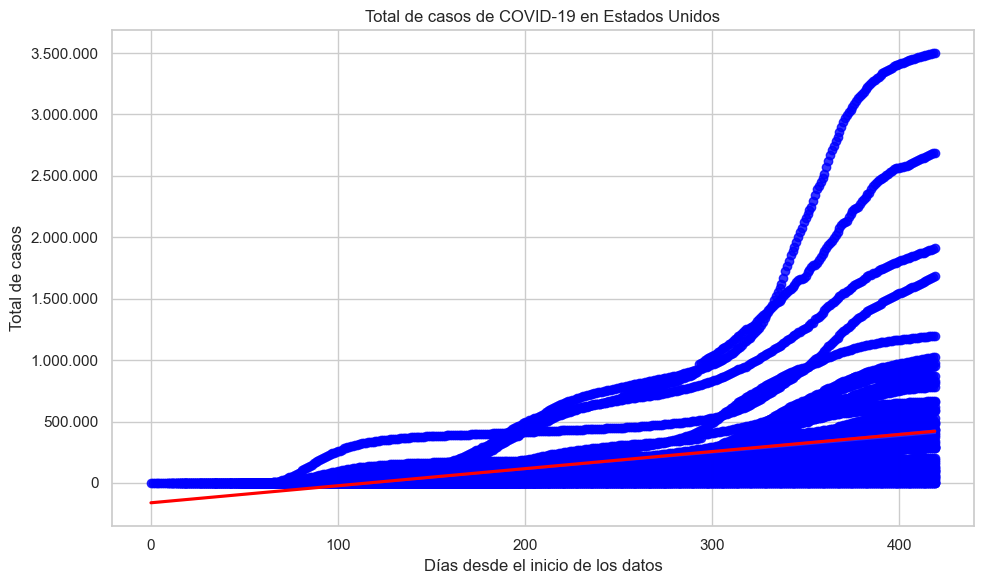

In [13]:
# Agrupar por 'state' y 'date' y sumar las columnas relevantes
totales_estado = df.groupby(['state', 'date']).sum().reset_index()

totales_usa = df.groupby('date').agg({
    'positive': 'sum',
    'death': 'sum',
    'recovered': 'sum',
}).reset_index()

display(HTML('<h4>Totales por estado</h4>'))
print(totales_estado.head(5))
display(HTML('<hr>'))
display(HTML('<h4>Totales en USA</h4>'))
print(totales_usa)

estados_de_eeuu = totales_estado['state'].unique().tolist() # Lista de estados
matplotlib.use('TkAgg') # Se pone matplolib para sacar los gráficos en pantalla.

## Gráfica para el total de Estados Unidos con Matplolib solamente
# Calcular los nuevos casos diarios y nuevas muertes diarias

# Convertir la columna 'date' a valores numéricos (días desde el inicio de los datos)
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Crear un gráfico de dispersión con ajuste de regresión con Seaborn
# Establecer el estilo de Seaborn
def format_y_axis(y, _):
    return '{:,.0f}'.format(y).replace(",", ".")

%matplotlib inline
sns.set(style="whitegrid")
sns.set_palette("muted")
plt.figure(figsize=(10, 6))
sns.regplot(x='days_since_start', y='positive', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_y_axis))  # Aplicar formato personalizado al eje Y
plt.title('Total de casos de COVID-19 en Estados Unidos')
plt.xlabel('Días desde el inicio de los datos')
plt.ylabel('Total de casos')
plt.tight_layout()
plt.show()

# Visualización por diagrama de barras del total de contagios y fallecimientos en el país a lo largo del periodo analizado

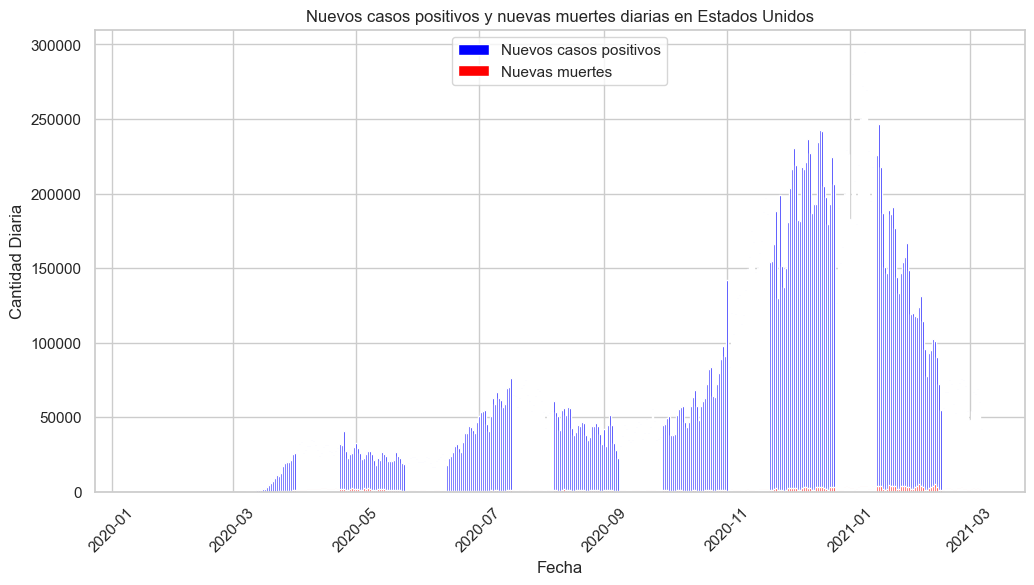

In [14]:
totales_usa['new_positive'] = totales_usa['positive'].diff()
totales_usa['new_death'] = totales_usa['death'].diff()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline
plt.figure(figsize=(12, 6))

# Utilizar plt.bar() en lugar de plt.plot()
plt.bar(totales_usa['date'], totales_usa['new_positive'], label='Nuevos casos positivos', color='blue')
plt.bar(totales_usa['date'], totales_usa['new_death'], label='Nuevas muertes', color='red')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Nuevos casos positivos y nuevas muertes diarias en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
# %matplotlib qt

# Obtener una gráfica de los datos totales

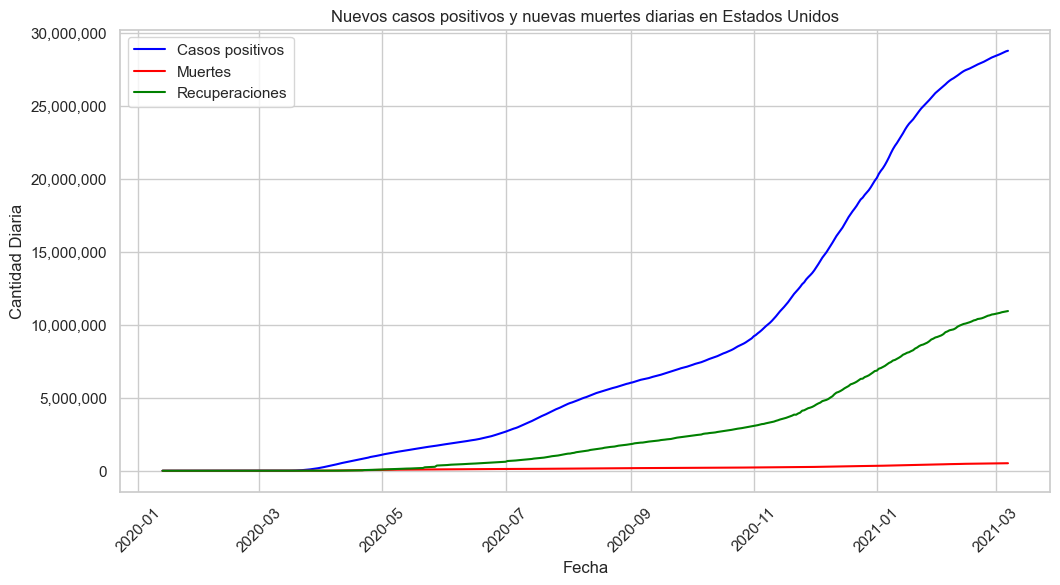

In [15]:
# Total de contagios y fallecimientos en todo el pais
totales_usa = df.groupby('date').agg({
    'positive': 'sum',
    'death': 'sum',
    'recovered': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['positive'], label='Casos positivos', color='blue')
plt.plot(totales_usa['date'], totales_usa['death'], label='Muertes', color='red')
plt.plot(totales_usa['date'], totales_usa['recovered'], label='Recuperaciones', color='green')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Nuevos casos positivos y nuevas muertes diarias en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
# %matplotlib qt

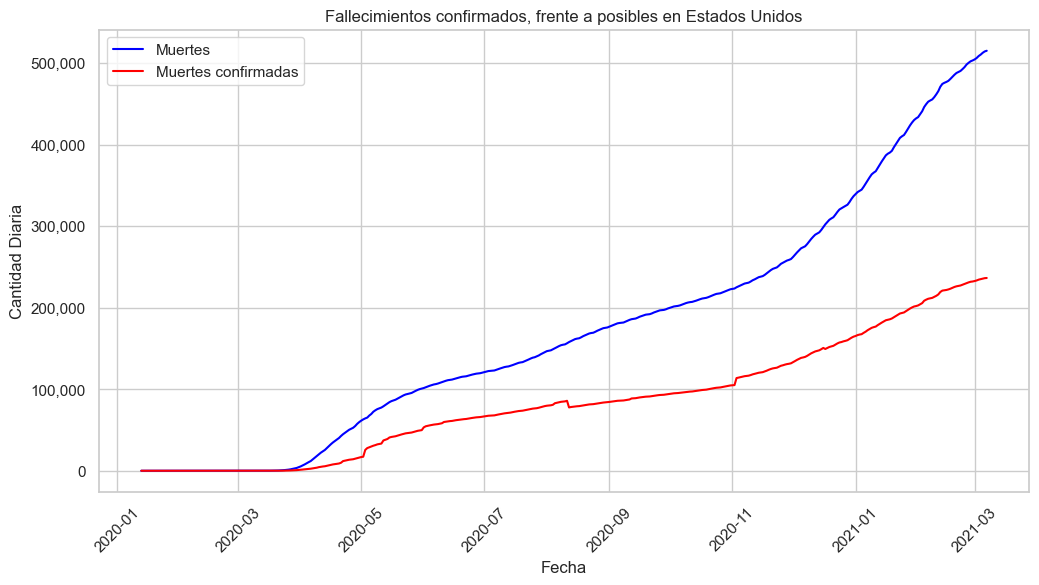

In [16]:
# Total de contagios y fallecimientos en todo el pais
totales_usa = df.groupby('date').agg({
    'death': 'sum',
    'deathConfirmed': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['death'], label='Muertes', color='blue')
plt.plot(totales_usa['date'], totales_usa['deathConfirmed'], label='Muertes confirmadas', color='red')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Fallecimientos confirmados, frente a posibles en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
# %matplotlib qt

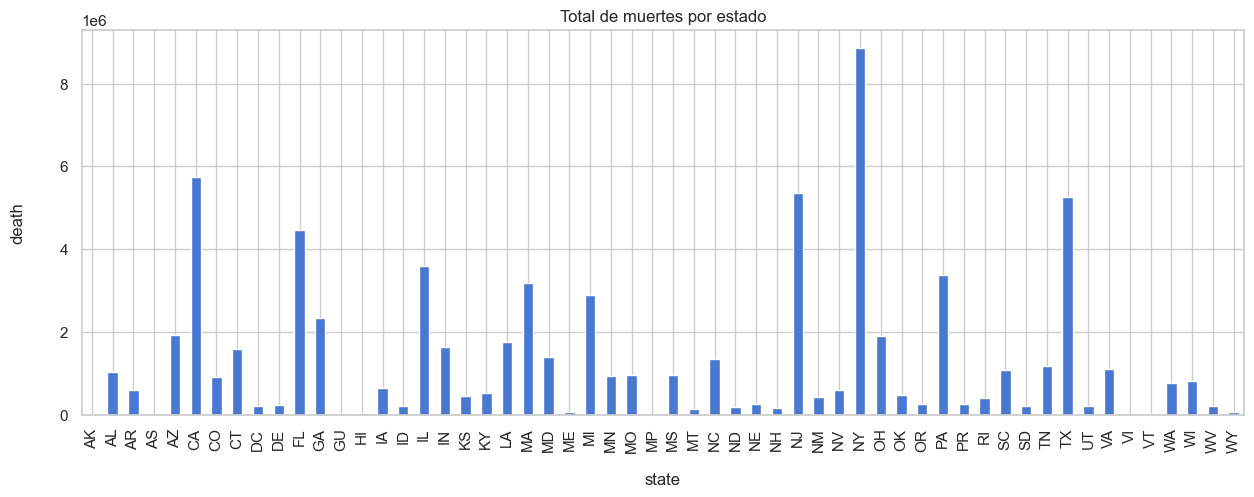

In [17]:
data_sum = df.groupby('state')['death'].sum()
plt.figure(figsize=(15, 5))
data_sum.plot.bar()
plt.xlabel('state', labelpad=14)
plt.ylabel('death', labelpad=25)
plt.title('Total de muertes por estado')
plt.show()

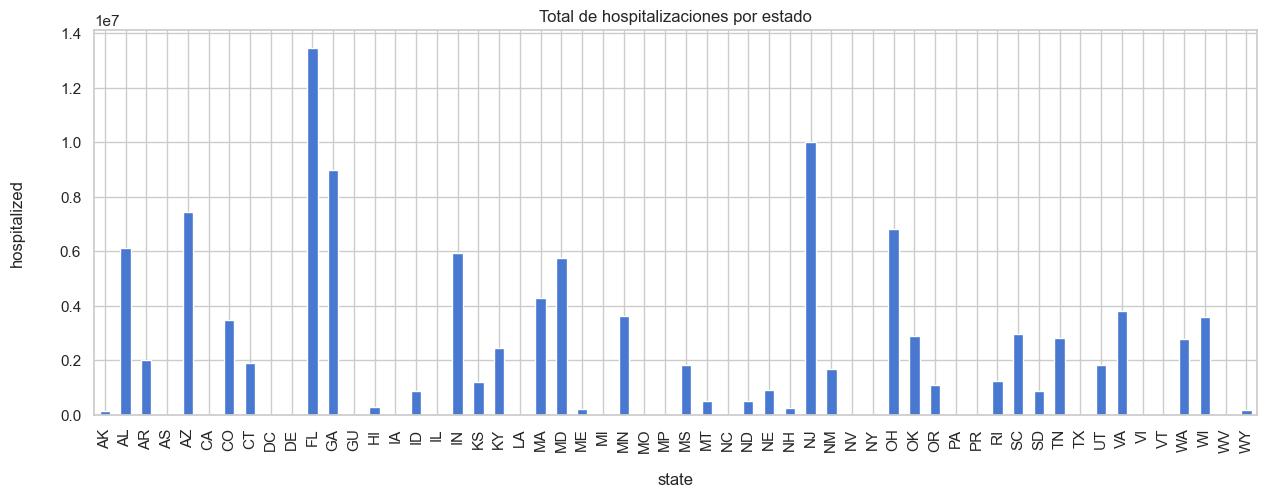

In [18]:
data_sum = df.groupby('state')['hospitalized'].sum()
plt.figure(figsize=(15, 5))
data_sum.plot.bar()
plt.xlabel('state', labelpad=14)
plt.ylabel('hospitalized', labelpad=25)
plt.title('Total de hospitalizaciones por estado')
plt.show()

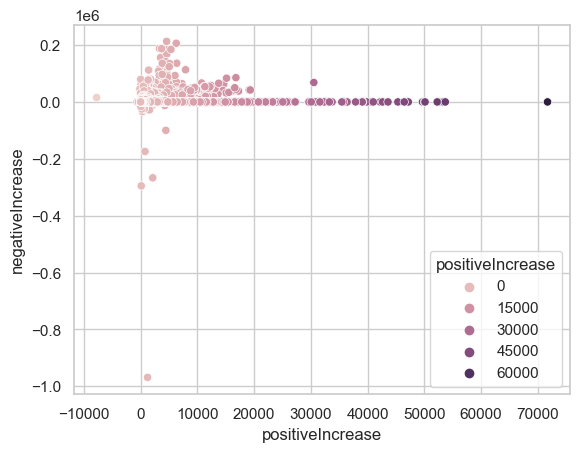

In [19]:
# Incremento de casos positivos y negativos.
# Si pasas una variable al argumento 'hue', los símbolos del gráfico se colorearán en base a esa variable.

sns.scatterplot(data=df, x='positiveIncrease', y= 'negativeIncrease', hue = 'positiveIncrease');

# Incrementos de muertes y hospitalizaciones

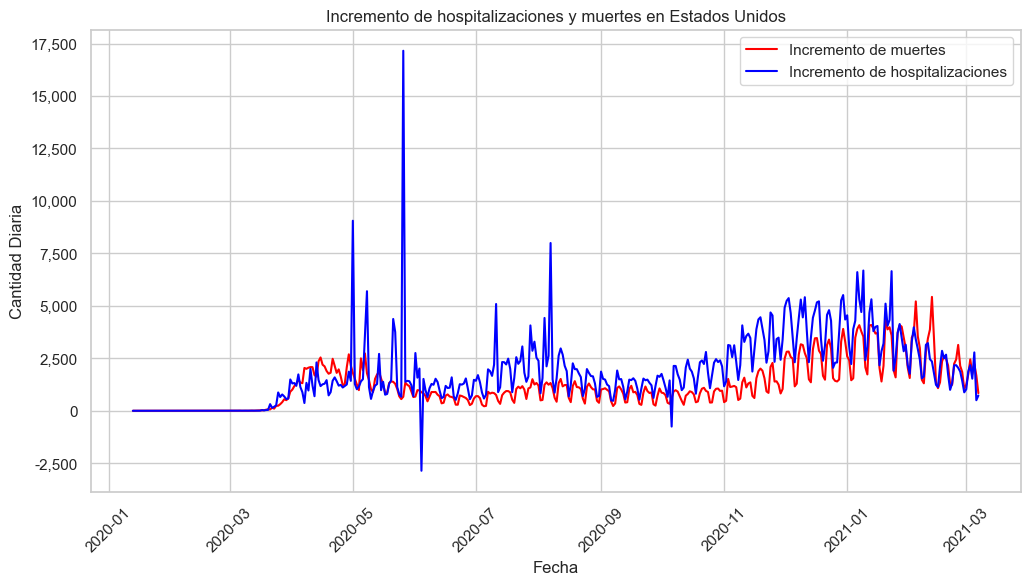

In [20]:
# Total de contagios y fallecimientos en todo el pais
totales_usa = df.groupby('date').agg({
    'deathIncrease': 'sum',
    'hospitalizedIncrease': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['deathIncrease'], label='Incremento de muertes', color='red')
plt.plot(totales_usa['date'], totales_usa['hospitalizedIncrease'], label='Incremento de hospitalizaciones', color='blue')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Incremento de hospitalizaciones y muertes en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
# %matplotlib qt

# La grafica anterior con bokeh

In [21]:
# Total de contagios y fallecimientos en todo el pais
totales_usa = df.groupby('date').agg({
    'deathIncrease': 'sum',
    'hospitalizedIncrease': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
output_notebook()

# Generar la gráfica con Bokeh.
p = figure(title='Incremento de hospitalizaciones y muertes en Estados Unidos',
           x_axis_label='Fecha', y_axis_label='Cantidad Diaria', x_axis_type='datetime', width=800, height=400)

p.line(totales_usa['date'], totales_usa['deathIncrease'], legend_label='Incremento de muertes', line_color='red')
p.line(totales_usa['date'], totales_usa['hospitalizedIncrease'], legend_label='Incremento de hospitalizaciones', line_color='blue')

# Formatear el eje y con separadores de miles
p.yaxis.formatter = NumeralTickFormatter(format='0,0')

# Agregar herramienta de información al pasar el ratón sobre la gráfica
hover = HoverTool(tooltips=[('Fecha', '@x{%F}'), ('Cantidad Diaria', '@y')],
                  formatters={'@x': 'datetime'})
p.add_tools(hover)

show(p)

Loading BokehJS ...

#### Se seleccionan la siguientes columnas en la que se reemplazan los valores nulos por cero, ya que se consideran pueden ser relevantes para el estudio futuro:

In [22]:
# Lista de columnas en las que desea sustituir los valores nulos por cero

col_replace = ['pending', 'onVentilatorCumulative', 'positiveTestsPeopleAntigen',
               'negativeTestsPeopleAntibody', 'negativeTestsAntibody', 'totalTestsAntibody',
               'totalTestsPeopleAntigen', 'positiveTestsPeopleAntibody', 'totalTestsAntigen',
               'positiveTestsAntibody', 'totalTestEncountersViral', 'deathProbable',
               'deathConfirmed', 'positiveTestsViral', 'totalTestsPeopleViral',
               'totalTestsAntibody', 'hospitalizedDischarged', 'totalTestsPeopleAntibody']

# Verificar si las columnas existen en el DataFrame

missing_columns = set(col_replace) - set(df.columns)

if missing_columns:
    
    print(f"Las siguientes columnas no existen en el DataFrame: {missing_columns}")
    
else:
    
    # Sustituir valores nulos por cero en las columnas seleccionadas
    
     for col in col_replace:
        df[col] = df[col].fillna(0)
        df[col] = pd.to_numeric(df[col], errors='coerce')

#### Teniendo en cuenta la cantidad de valores faltantes y por el estudio de los datos que se pretende realizar, se considera ignorar las siguientes columnas:

In [23]:
# Lista de columnas que no desean utilizar

col_drop = ['hash', 'commercialScore', 'negativeRegularScore', 'negativeScore',
            'positiveScore', 'score', 'grade', 'dataQualityGrade', 'fips']

In [24]:
# Se crea un nuevo DataFrame sin las columnas que no deseas utilizar
# para no modificar permanentemente el df original.

df_fil = df.drop(columns=col_drop)

In [25]:
# Análisis estadístico básico

df_fil.describe()

,date,positive,probableCases,negative,pending,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,...,totalTestsAntigen,positiveTestsAntigen,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,days_since_start
count,20780,2.078000e+04,20780.000000,2.078000e+04,20780.000000,2.078000e+04,20780.000000,20780.000000,20780.000000,20780.000000,...,2.078000e+04,20780.000000,20780.000000,20780.000000,2.078000e+04,20780.000000,2.078000e+04,20780.000000,20780.000000,20780.000000
mean,2020-09-02 18:13:30.779595776,1.636618e+05,9694.451684,5.424882e+05,170.778970,2.169466e+06,993.427045,5519.322666,201.374013,352.678152,...,5.085726e+04,3421.201155,1383.849519,3589.128874,7.063208e+05,17508.388210,7.061500e+05,24.790712,37.360780,233.759384
min,2020-01-13 00:00:00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,-7757.000000,-968686.000000,0.000000e+00,-130545.000000,0.000000e+00,-201.000000,-12257.000000,0.000000
25%,2020-06-02 00:00:00,5.266000e+03,0.000000,0.000000e+00,0.000000,9.682300e+04,46.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,65.000000,0.000000,2.577975e+04,1205.750000,2.565875e+04,0.000000,0.000000,141.000000
50%,2020-09-03 00:00:00,4.486100e+04,0.000000,3.730150e+04,0.000000,6.424245e+05,370.000000,462.000000,19.000000,0.000000,...,0.000000e+00,0.000000,435.000000,141.500000,1.937255e+05,6125.000000,1.935810e+05,6.000000,0.000000,234.000000
75%,2020-12-05 00:00:00,1.756140e+05,3101.500000,5.322208e+05,0.000000,2.243481e+06,1051.000000,6411.000000,209.000000,0.000000,...,0.000000e+00,0.000000,1335.250000,3916.000000,7.737408e+05,19086.500000,7.737408e+05,24.000000,36.000000,327.000000
max,2021-03-07 00:00:00,3.501394e+06,365961.000000,1.018694e+07,64400.000000,4.964601e+07,22851.000000,82237.000000,5225.000000,9263.000000,...,2.664340e+06,211546.000000,71734.000000,212974.000000,1.125679e+07,473076.000000,1.124825e+07,2559.000000,16373.000000,419.000000
std,NaN,3.256792e+05,32235.136511,1.149762e+06,1580.577054,4.423038e+06,1933.097380,10750.201894,479.571454,1119.533486,...,2.064328e+05,16913.591602,3023.558742,11577.190442,1.300339e+06,33586.022461,1.299997e+06,60.162742,208.237151,107.494531


In [26]:
numericas = df_fil.select_dtypes(include=['int64', 'float64']).columns

print("Columnas numéricas:")
display(HTML(numericas.to_frame().to_html(index=False)))

categoricas = df_fil.select_dtypes(include=['object']).columns

print("\nColumnas categoricas:\n[{}]".format(", ".join(categoricas)))

Columnas numéricas:


0
positive
probableCases
negative
pending
totalTestResults
hospitalizedCurrently
hospitalizedCumulative
inIcuCurrently
inIcuCumulative
onVentilatorCurrently



Columnas categoricas:
[state, totalTestResultsSource, lastUpdateEt, dateModified, checkTimeEt, dateChecked]


#### Observamos que despues de limpiar la data, y pasar de 56 columnas a 42, la grafica es prácticamente igual

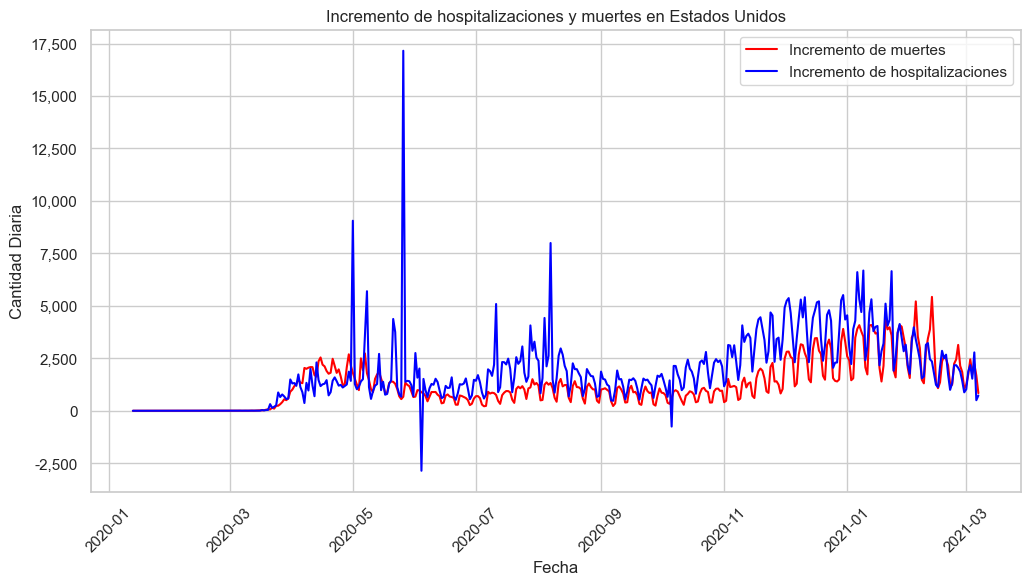

In [27]:
# Total de contagios y fallecimientos en todo el pais
totales_usa = df_fil.groupby('date').agg({
    'deathIncrease': 'sum',
    'hospitalizedIncrease': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['deathIncrease'], label='Incremento de muertes', color='red')
plt.plot(totales_usa['date'], totales_usa['hospitalizedIncrease'], label='Incremento de hospitalizaciones', color='blue')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Incremento de hospitalizaciones y muertes en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
# %matplotlib qt

# CONCLUSIONES.
De la visualización de los gráficos obtenidos, tanto por estados como global del país, se infiere que, en el perido analizado, entre enero de 2020 y marzo de 2021, se infieren las siguientes conclusiones:

- En el periodo inicial no había prácticamente casos tipificados, pero sí se registraron muertes que fueron atribuidas al covid.
- En un breve periodo de tiempo se empezaron a registrar casos de contagios, que aumentaban rápidamente. Esto refleja que las medidas de contención y aislamiento no fueron efectivas, o no tanto como habría sido deseable.
- Sin embargo, las cifras de defunciones atribuidas al covid se mantienen casi estables en el tiempo. Esto relfeja que las actividades sanitarias para curar a los enfermos fueron altamente efectivas, logrando mantener a raya los números de fallecimientos.
- También se observa una clara relación entre hositalizaciones y fallecimientos. Esto muestra como los hospitales son centros de riesgo en el tratamiento de la enfermedad.

### En todos los gráficos, nos centramos en los valores más relevantes: las columnas <code>positive</code> (contagios positivos registrados) y <code>death</code> (fallecimientos)

Hasta los 64 días desde el inicio del periodo contemplado no empiezan a registrarse casos de contagios, o estos no constan en el archivo de datos. Probablemente, en ese periodo hubiera cierta expansión de contagios que no se han reflejado.
Sin embargo, desde el momento en que empiezan a registrarse contagios, es de suponer que se pusieron medios sanitarios para restablecer la salud de las víctimas, logrando mantener muy bajo el número de fallecimientos.

La conclusión obvia es que conocer la magnitud de la pandemia, y poner los medios adecuados, logró salvar innumerables vidas.

### Recuperaciones.
Cabría esperar que el número de recuperaciones y de fallecimientos sumaran el total de contagios, pero no es así. De esto se deduce que los datos no están completos.

### Se echan en falta.
Se echan en falta en la fuente de datos, temas como la edad, el sexo, la raza, la profesión, la posición social, lo que podría darnos una demográfica más exacta.